In [1]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

### Preparing the Data

In [2]:
transform=T.Compose([T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True, transform=transform)

In [3]:
def binary_clf_dataset(data, labels, neg_class=0, pos_class=1, size=1000, seed=0):
    rng = torch.Generator()
    rng.manual_seed(seed)
    labels_tensor = torch.Tensor(labels).long()
    mask = torch.zeros(labels_tensor.shape, dtype=torch.bool)
    idx = torch.nonzero(labels_tensor == neg_class)[:, 0]
    idx = idx[torch.randperm(len(idx), generator=rng)[:size//2]]
    mask[idx] = True
    idx = torch.nonzero(labels_tensor == pos_class)[:, 0]
    idx = idx[torch.randperm(len(idx), generator=rng)[:size//2]]
    mask[idx] = True
    binary_labels = labels_tensor[mask]
    binary_labels[binary_labels == neg_class] = 0
    binary_labels[binary_labels == pos_class] = 1
    binary_labels = binary_labels.tolist()
    binary_data = data[mask]
    return binary_data, binary_labels

In [4]:
train_dataset.data, train_dataset.targets = binary_clf_dataset(train_dataset.data, train_dataset.targets)

In [5]:
print(f'dataset size: {len(train_dataset)}, number of classes: {max(train_dataset.targets)+1}')

dataset size: 1000, number of classes: 2


In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

### Training the Network

In [7]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [8]:
# Play around with the network's architecture. Change the depth, width, activation, etc..
# For example try linear activation by replacing nn.ReLU() with nn.Identity().
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32*32*3, 128, bias=False),
    nn.ReLU(),
    nn.Linear(128, 128, bias=False),
    nn.ReLU(),
    nn.Linear(128, 128, bias=False),
    nn.ReLU(),
    nn.Linear(128, 1))
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=128, bias=False)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=128, bias=False)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=128, bias=False)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=1, bias=True)
)


In [9]:
critertion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
num_epoch = 100
model.train()
for epoch in range(num_epoch):
    train_loss = 0.0
    batch_cnt = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predict = model(batch_X)
        loss = critertion(predict, batch_y.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        batch_cnt += 1

    if (epoch + 1) % 10 == 0:
        print(f'epoch: {epoch}, train loss: {train_loss/batch_cnt}')

epoch: 9, train loss: 0.055221106857061386
epoch: 19, train loss: 0.017858062419691123
epoch: 29, train loss: 0.00027390173181629507
epoch: 39, train loss: 0.00011177455075994658
epoch: 49, train loss: 6.065116349418531e-05
epoch: 59, train loss: 3.754453257442947e-05
epoch: 69, train loss: 2.5314709887425124e-05
epoch: 79, train loss: 1.8092143818648765e-05
epoch: 89, train loss: 1.443024348191102e-05
epoch: 99, train loss: 1.0185814176111307e-05


### Extracting Representations

In [11]:
from torchvision.models.feature_extraction import get_graph_node_names
all_nodes, _ = get_graph_node_names(model)
# These are all the model's nodes.
print(all_nodes)

['input', '0', '1', '2', '3', '4', '5', '6', '7']


In [12]:
from torchvision.models.feature_extraction import create_feature_extractor
# These are the nodes we extract the representations from.
# If you change the architecture you may need to change this array.
nodes = ['0', '2', '4', '6']
model.eval()
feature_extractor = create_feature_extractor(model, return_nodes=nodes)

In [13]:
input_data = []
targets = []
for batch_X, batch_y in train_loader:
    input_data.append(batch_X)
    targets.append(batch_y)
input_data = torch.vstack(input_data)
targets = torch.hstack(targets)
print(input_data.shape, targets.shape)

torch.Size([1000, 3, 32, 32]) torch.Size([1000])


In [14]:
reps = feature_extractor(torch.Tensor(input_data.data))
print([(key, rep.shape) for (key, rep) in reps.items()])

[('0', torch.Size([1000, 3072])), ('2', torch.Size([1000, 128])), ('4', torch.Size([1000, 128])), ('6', torch.Size([1000, 128]))]


### Computing Alignment

In [15]:
# This function computes the alignment curve efficiently.
def get_alignment_curve(dot_products, y, s, grid):
    cumu_grid_len = len(grid)-1
    cumu = np.zeros(cumu_grid_len+1)
    cumu_ind = 0
    for s_ind, this_s in enumerate(s):
        while grid[cumu_ind] > this_s:
            cumu_ind += 1
            cumu[cumu_ind] += cumu[cumu_ind-1]
        cumu[cumu_ind] += dot_products[s_ind]
    cumu[cumu_ind+1:-1] = cumu[cumu_ind]
    cumu[-1] = (y**2).sum()
    return cumu

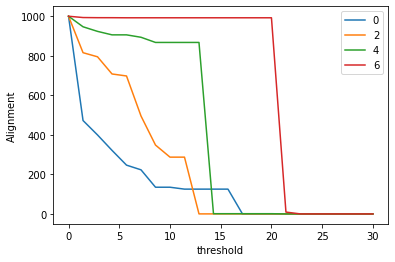

In [16]:
# Creating +-1 label vector
y = targets.float() * 2 - 1

for key, phi in reps.items():
    # Adding a constant 1 feature to account for the bias unit
    bias_feature = torch.ones(phi.shape[0], 1).float()
    phi_bias = torch.hstack((phi, bias_feature))

    # Normalizing each row
    phi_norm = phi_bias / torch.linalg.norm(phi_bias, dim=1)[:, None]

    u, s, vt = torch.linalg.svd(phi_norm)
    dot_products = (u.T @ y)**2
    
    grid = np.linspace(0, 30, (10+1)*2)[::-1]
    alignment_curve = get_alignment_curve(
        dot_products.detach().numpy(), y.detach().numpy(), s.detach().numpy(), grid)[::-1]

    plt.plot(grid[::-1], alignment_curve, label=key)
plt.legend()
plt.ylim(ymin=-50)
plt.ylabel('Alignment')
plt.xlabel('threshold')
plt.show()